# Modelo de análise das métricas RFM

## Introdução

Uma empresa de e-commerce está buscando entender melhor o comportamento de seus clientes para personalizar as suas campanhas de marketing. Para isso, ela disponibilizou uma base de dados em csv contendo informações a sobre os clientes, produtos e transações realizadas entre os anos de 2010 e 2011.

## Objetivo do projeto

A partir da base de dados disponibilizada, o presente projeto tem como objetivo desenvolver um modelo de machine learning de Clusterização que permita analisar as métricas RFM destes clientes, agrupando-os os em clusters com base em seu comportamento de compra, identificando padrões e características comuns dentro destes grupos.

A partir disso, ainda é necessário explicar de que forma esta análise pode ser útil para a empresa, no intuito de segmentar seus clientes e personalizar campanhas de marketing, sugerindo ações possíveis para cada um dos grupos identificados.

## Sobre os dados

Os dados fornecidos possuem informações de transações de compras da empresa realizada em 38 países diferentes, com mais de 4.000 clientes únicos e mais de 540.000 transações.

Segue abaixo um descritivo do significado das informações presentes em cada coluna do dataset.

- InvoiceNo: Identificação da transação;
- StockCode: Código de estoque do produto;
- Description: Descrição do produto;
- Quantity: Quantidade de produtos por transação;
- InvoiceDate: Data da transação;
- UnitPrice: Preço unitário do produto;
- CustomerID: Identificação do cliente;
- Country: País de origem da transação.

## Bibliotecas utilizadas

Para o desenvolvimento deste projeto foram utilizadas as seguintes bibliotecas do Python,

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, PowerTransformer

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from yellowbrick.cluster import kelbow_visualizer, silhouette_visualizer

## Análise exploratória dos dados

Importadas as bibliotecas, utilizou-se o Pandas para carregar o dataset disponibilizado,

In [2]:
df = pd.read_csv('data.csv', encoding='latin-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Exibindo-se mais informações a respeito do dataset,

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Avaliando-se o resultado acima, percebe-se que as colunas de InvoiceNo e StockCode apresentam dados do tipo object. Plotando-se abaixo mais detalhes destas colunas,

In [4]:
df['InvoiceNo'].sort_values()

0          536365
1          536365
2          536365
3          536365
4          536365
           ...   
540449    C581490
541541    C581499
541715    C581568
541716    C581569
541717    C581569
Name: InvoiceNo, Length: 541909, dtype: object

In [5]:
df['StockCode'].sort_values()

160128           10002
6166             10002
75792            10002
63082            10002
76571            10002
              ...     
42057     gift_0001_50
178556    gift_0001_50
245516    gift_0001_50
239744    gift_0001_50
40383                m
Name: StockCode, Length: 541909, dtype: object

Para ambas as colunas percebe-se a ocorrência de caracteres alfabéticos em alguns dos códigos, ou seja, dados do tipo string, texto. Por isso estas colunas são do tipo object. Como elas representam códigos (conforme descrito anteriormente na sessão 'Sobre os dados' deste notebook), então optou-se por mantê-las desta forma.

Outro ponto importante é que a coluna 'InvoiceDate' apresenta informações de data e horário das transações, contudo ela está com dados do tipo 'object'. Desta forma, é necessário convertê-los para dados do tipo data (datetime). Para isso, realizou-se o código abaixo.

In [6]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format = '%m/%d/%Y %H:%M')

Conferindo agora o tipo de dado desta coluna,

In [7]:
df['InvoiceDate']

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541904   2011-12-09 12:50:00
541905   2011-12-09 12:50:00
541906   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 541909, dtype: datetime64[ns]

Logo, todos os seus dados de entrada foram convertidos para data.

Analisando-se os dados da coluna 'Description',

In [8]:
df['Description'].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER     2369
REGENCY CAKESTAND 3 TIER               2200
JUMBO BAG RED RETROSPOT                2159
PARTY BUNTING                          1727
LUNCH BAG RED RETROSPOT                1638
                                       ... 
Missing                                   1
historic computer difference?....se       1
DUSTY PINK CHRISTMAS TREE 30CM            1
WRAP BLUE RUSSIAN FOLKART                 1
PINK BERTIE MOBILE PHONE CHARM            1
Name: Description, Length: 4223, dtype: int64

In [9]:
df['Description'].nunique()

4223

Conforme descrito anteriormente, esta coluna se trata da descrição de cada um dos produtos. Tem-se ao todo 4223 produtos diferentes vendidos nesta empresa de e-commerce.

Avaliando-se agora a distribuição dos dados da coluna "Country". Plotou-se abaixo um gráfico de barras horizontal, ordenadas do maior para o menor valor, mostrando a frequência de cada um dos países em porcentagem no dataset.

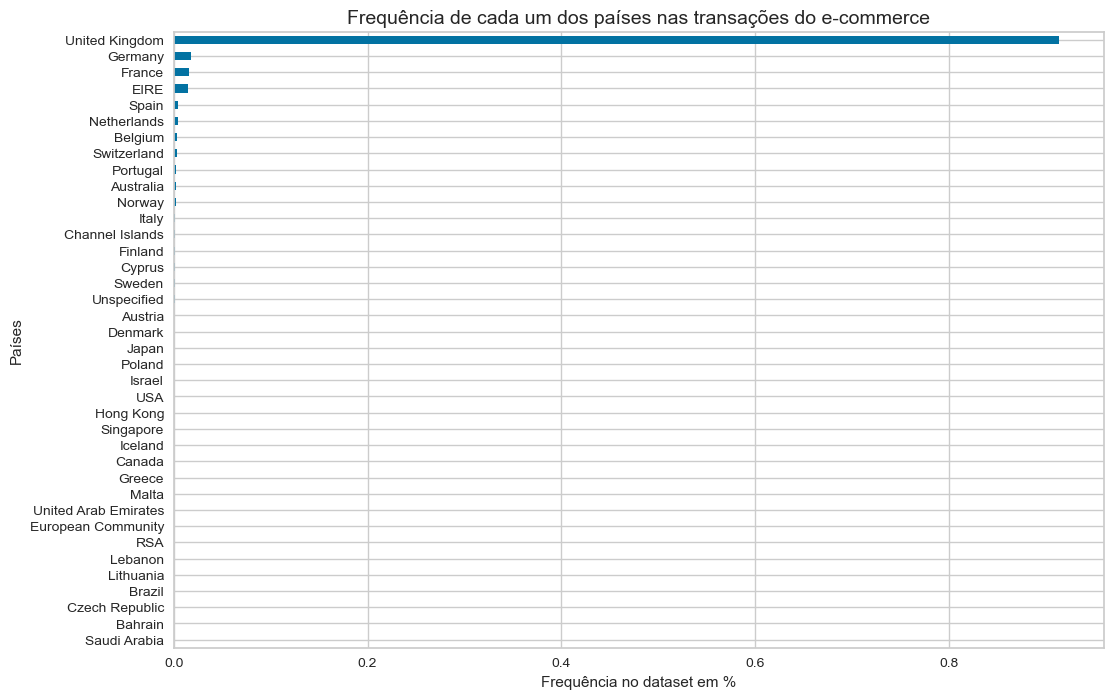

In [10]:
plt.figure(figsize = (12,8))
df['Country'].value_counts(normalize = True, ascending = True).plot.barh()
plt.title('Frequência de cada um dos países nas transações do e-commerce', fontsize = 14, loc = 'center')
plt.ylabel('Países')
plt.xlabel('Frequência no dataset em %')
plt.show()

Percebe-se que a maioria esmagadora dos casos de transações registrados nesta empresa de e-commerce se encontra no Reino Unido, com uma ocorrência de mais de 80% dos casos. Seguidamente vem Alemanha, França e EIRE.

Mostrando a quantidade de casos dos 10 primeiros países,

In [11]:
df['Country'].value_counts().head(10)

United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         2002
Portugal            1519
Australia           1259
Name: Country, dtype: int64

Portanto o Reino Unido tem ao todo 495478 casos de transações. Considerando-se apenas os primeiros 4 países (visto que a quantidade de casos desses em comparação aos demais é grande), calculou-se quanto eles representam do total de países, conforme demonstrado abaixo.

In [15]:
qtd_relativa = (df['Country'].value_counts().head(4).sum())/(df.shape[0])

print(f'{qtd_relativa:.2%}')

96.28%


Ou seja, 96,28% de todas as compras foram realizadas no Reino Unido ou Alemanha ou França ou EIRE.

Analisando-se agora as estatísticas descritivas das colunas numéricas presentes no dataset (exceto a coluna "CustomerID" pois só representa a codificação dos clientes),

In [16]:
df.drop(columns = ['CustomerID']).describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


Primeiro ponto de atenção importante: ambas as colunas apresentam dados NEGATIVOS. Isto não faz sentido neste caso pois se tratam de informações a respeito da quantidade de produtos vendidos em cada transação e do preço unitário dos produtos. Portanto este problema deve ser corrigido antes da modelagem.

Segundo ponto de atenção importante: outliers. Ambas as colunas apresentam outliers claros, visto que os valores máximos encontrados em cada uma delas é bem maior do que o terceiro quartil (75% dos dados).

Ambos estes problemas, juntamente com o tratamento de dados nulos, serão abordados na sessão seguinte "Data Preparation".

## Data Preparation

### Dados nulos

Exibindo-se novamente as infos das colunas,

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Percebe-se que existem dados nulos, tanto na coluna de "Description" quanto na coluna de "CustomerID".

Para avaliar esta quantidade de forma mais precisa, exibe-se a tabela abaixo com as quantidades totais de dados nulos e quanto isto representa em porcentagem se comparado ao total de linhas de cada coluna.

In [18]:
def missing_data(df):

  missing_df = (
    df.isnull().sum().to_frame('missing_count')
    .join(((df.isnull().sum())/df.shape[0]).to_frame('missing_pct'))
  )

  return missing_df.style.format('{:.2%}', subset = 'missing_pct')

In [19]:
missing_data(df)

,missing_count,missing_pct
InvoiceNo,0,0.00%
StockCode,0,0.00%
Description,1454,0.27%
Quantity,0,0.00%
InvoiceDate,0,0.00%
UnitPrice,0,0.00%
CustomerID,135080,24.93%
Country,0,0.00%


Tem-se então uma quantidade de dados nulos na coluna 'Description' na faixa de 0.27%, valor este relativamente pequeno. Contudo, na coluna 'CustomerID' tem-se um total de 24.93% de dados nulos. Esta quantidade pode ser considerada alta. O grande "X" da questão neste caso é que não existem mais informações a respeito destes clientes com código de identifação nulo. Não se sabe se foi um erro de preenchimento ao cadastrar o cliente, ou se tem algum outro porém. O ideal neste caso seria conversar com a empresa para entender de forma tratar isto.

Como aqui é um cenário genérico, por falta de informações optou-se por excluir todas as linhas com 'CustomerID' nulo, conforme segue abaixo.

In [20]:
df = df.dropna(subset = ['CustomerID'])

Mostrando agora a nova quantidade de dados nulos no dataset,

In [21]:
missing_data(df)

,missing_count,missing_pct
InvoiceNo,0,0.00%
StockCode,0,0.00%
Description,0,0.00%
Quantity,0,0.00%
InvoiceDate,0,0.00%
UnitPrice,0,0.00%
CustomerID,0,0.00%
Country,0,0.00%


Excluindo-se as linhas com dados nulos da coluna "CustomerID", também excluiu-se junto as linhas da coluna "Description". Assim, o dataset não apresenta mais dados nulos.

Antes de seguir com a análise seguinte, optou-se por transformar os dados da coluna "CustomerID", pois, conforme visto anteriormente, tem dados de identificação dos clientes, ou seja, códigos. Logo, estes não precisam ser dados do tipo "float" e sim "int".

In [22]:
df['CustomerID'] = df['CustomerID'].astype('int')

### Linhas duplicadas

Avaliando a existência de linhas duplicadas no dataset,

In [23]:
df.duplicated().sum()

5225

Portanto, existem 5225 linhas com dados duplicados neste dataset. Imprimindo algumas delas em tela,

In [24]:
df_duplicated = df[df.duplicated(keep = False)]
df_duplicated

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446,United Kingdom
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446,United Kingdom


Selecionando os casos do cliente 17908, por exemplo,

In [25]:
df_duplicated[df_duplicated['CustomerID']==17908]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom


Aparentemente, estes casos de linhas duplicadas podem ter sido gerados por algum tipo de erro do sistema, pois não faz sentido o mesmo cliente ter comprado exatamente o mesmo produto na mesma hora e ter sido gerado o mesmo código de transação e o mesmo código de estoque duas vezes.

Assim, optou-se por excluir do dataset estas linhas duplicadas, conforme segue.

In [26]:
df = df.drop_duplicates()

In [27]:
df.duplicated().sum()

0

### Dados negativos das colunas 'Quantity' e 'UnitPrice'

Para realizar este tratamento, optou-se por filtrar o dataset original, de forma a selecionar apenas as linhas com dados de quantidade e preço unitário positivos. Isto está demonstrado no código a seguir.

In [28]:
df = df[(df['Quantity']>0)&(df['UnitPrice']>0)]

In [29]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


Assim, não existem mais dados negativos no dataset.

### Outliers

Fazendo agora um boxplot das colunas 'Quantity' e 'UnitPrice'.

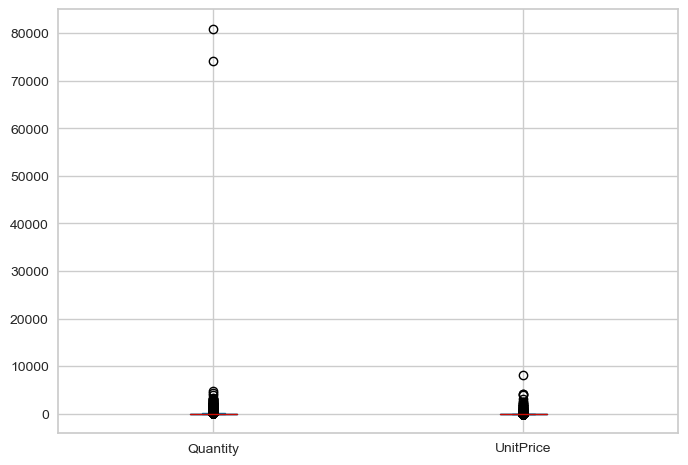

In [30]:
df[['Quantity', 'UnitPrice']].plot.box();

Pelo gráfico acima, percebe-se a existência clara de dois outliers extremos na coluna 'Quantity'.Explorando estes casos,

In [31]:
df[df['Quantity']>10000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


Fazendo uma filtragem para plotar um gráfico Boxplot somente dos casos com quantidade de produto vendido menor que 10.000,

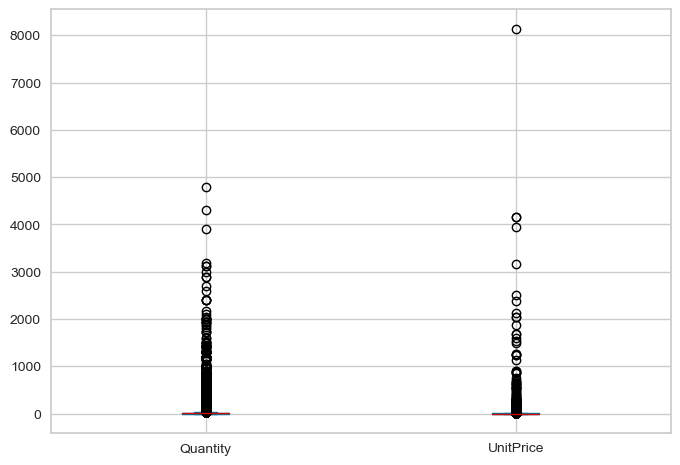

In [32]:
df[df['Quantity']<10000][['Quantity', 'UnitPrice']].plot.box();

Agora, tem-se outro outlier extremo, porém na coluna de "UnitPrice". Identificando este caso,

In [33]:
df[df['UnitPrice']>8000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom


Como estes 3 casos apresentam dados muito fora dos demais e visto que alguns modelos de clusterização são sensíveis a outliers, optou-se por excluir todos eles.

- 2 casos com quantidade de produtos vendidos acima de 10.000 em uma única transação;
- 1 caso de produto com preço unitário acima de $8.000,00

Este processo de exclusão será feito filtrando o dataset original, conforme demonstrado a seguir.

In [34]:
df = df[(df['Quantity']<1000)&(df['UnitPrice']<8000)]

### Cálculo da coluna de valor total

Definiu-se a nova coluna de preço total 'price_total', que nada mais é do que a multiplicação da quantidade de produtos vendidos pelo preço unitário por produto.

In [35]:
df['TotalPrice'] = df['Quantity']*df['UnitPrice']
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


### RFM

Agora é possível fazer o cálculo da métrica RFM por cliente. Para recapitular este conceito, RFM pode ser definido por:

- R (Recency): Quantidade dias de dias que o cliente realizou a sua última compra;
- F (Frequency): Quantidade de compras realizadas pelo cliente;
- M (Monetary): Valor do ticket médio gasto pelo cliente.

Assim, para o cálculo da Recência, primeiro é necessária a data da última compra registrada no e-commerce. Com este dado em mãos, ai sim é possível fazer a diferença de dias entre a última compra do site e a última compra de cada cliente em específico.

Como foi convertido anteriormente os dados da coluna "InvoiceDate" para datetime, isto permite utilizar a função max( ) para encontrar o último dia registrado no dataset, conforme segue abaixo.

In [36]:
last_date = df['InvoiceDate'].max()

In [37]:
last_date

Timestamp('2011-12-09 12:50:00')

Agora, definiu-se um novo data frame que irá receber os dados de RFM. Este data frame é o df agrupado por 'CustomerID', onde, para cada uma das métricas do RFM diferente (Recência, Frequência e Monetário) utilizou-se uma função de agregação diferente, conforme o que se pretende calcular em cada uma delas.

OBS: lembrando que para passar as funções de agregação por coluna, dentro do .agg(), primeiro se escreve o nome da coluna (R, F e M) e, para cada coluna, é necessário definir uma tupla, onde o primeiro elemento é a coluna de interesse que se deseja agregar e o segundo é a função de agregação.

In [38]:
df_rfm = (
  df.groupby('CustomerID')
  .agg(
      R = ('InvoiceDate', lambda x: (last_date - x.max()).days),
      F = ('InvoiceNo', 'nunique'),
      M = ('TotalPrice', 'mean')
  )
)

df_rfm

,R,F,M
CustomerID,,,
12347,1,7,23.681319
12348,74,4,57.975484
12349,18,1,24.076027
12350,309,1,19.670588
12352,35,8,29.482824
...,...,...,...
18280,277,1,18.060000
18281,180,1,11.545714
18282,7,2,14.837500


Avaliando-se agora a distribuição destes dados de RFM utilizando um gráfico de Boxplot.

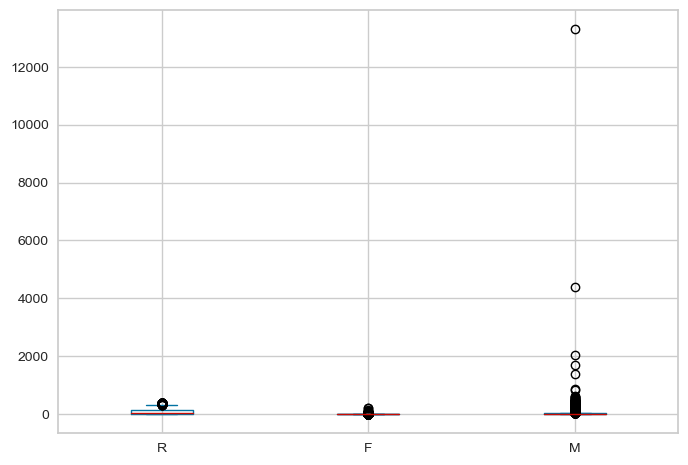

In [39]:
df_rfm.plot.box();

Como os dados destas colunas apresentam escalas numéricas muito diferentes uma das outras, é necessário normatizá-los para melhorar a visualização dos resultados no gráfico acima e também é um processo necessário de pré-processamento em modelos de clusterização.

Assim, para realizar tal processo utiliza-se da função scale da biblioteca scikit-learn importada anteriormente.

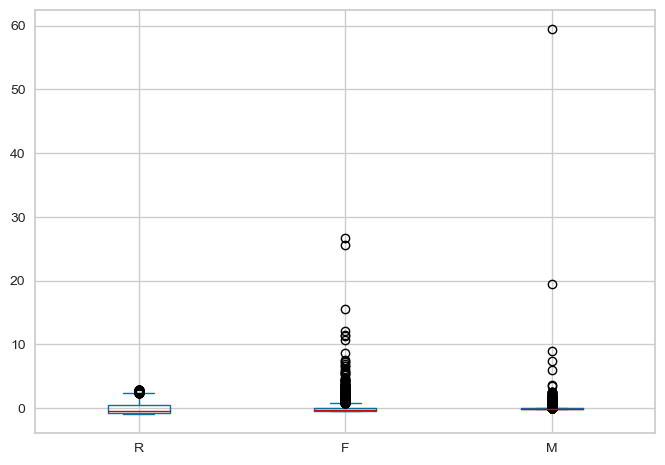

In [40]:
df_rfm.apply(scale).plot.box();

Com o resultado acima é possível perceber a presença de um outlier extremo na coluna "M". Selecionando este outlier para análise,

In [41]:
df_rfm.apply(scale).query('M>50')

,R,F,M
CustomerID,,,
15098,0.89562,-0.165217,59.452246


Identificou-se o cliente "CustomerID" = 15098. Verificando as compras realizadas por este cliente no dataset original,

In [42]:
df.query('CustomerID==15098')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
222670,556442,22502,PICNIC BASKET WICKER SMALL,60,2011-06-10 15:22:00,4.95,15098,United Kingdom,297.0
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,38970.0
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098,United Kingdom,649.5


Como os dados de compra deste cliente são incoerentes (aparentemente ele comprou 60 unidades de um produto que já vinha com 60 itens), optou-se por excluir as 3 compras deste cliente do data frame de rfm.

In [43]:
df_rfm = df_rfm.drop(15098)

Plotando novamente o gráfico de Boxplot,

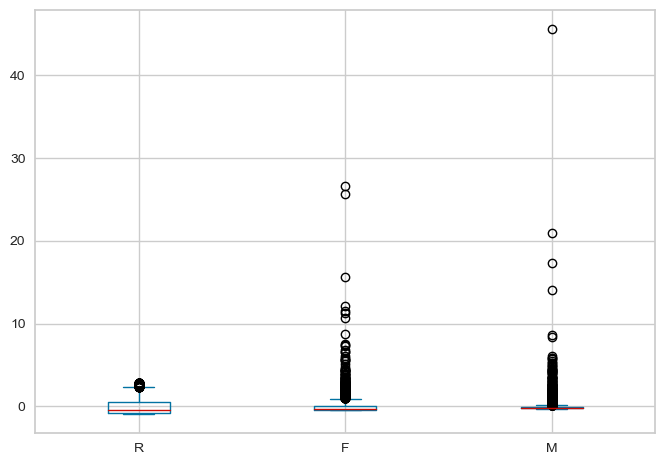

In [44]:
df_rfm.apply(scale).plot.box();

Para tratar os outliers restantes, optou-se por fazer uma normatização utilizando uma função de pré-processamento de dados da biblioteca scikit-learn, a chamada PowerTransformer. Esta função irá transformar os dados de tal forma a estabelecer distribuições normais em cada coluna, ou seja, com média próxima de zero e desvio padrão próximo de 1.

Definindo o transformador,

In [45]:
scaler = PowerTransformer()

Transformando os dados de rfm,

In [46]:
df_rfm_scaled = pd.DataFrame(scaler.fit_transform(df_rfm), index = df_rfm.index, columns = df_rfm.columns)
df_rfm_scaled

,R,F,M
CustomerID,,,
12347,-1.845581,1.201946,0.412035
12348,0.291572,0.661205,1.357873
12349,-0.680383,-1.156713,0.431409
12350,1.574383,-1.156713,0.189522
12352,-0.256935,1.309642,0.662907
...,...,...,...
18280,1.464211,-1.156713,0.083989
18281,1.050146,-1.156713,-0.499864
18282,-1.183052,-0.194676,-0.166154


Plotando o gráfico Boxplot dos dados já transformados,

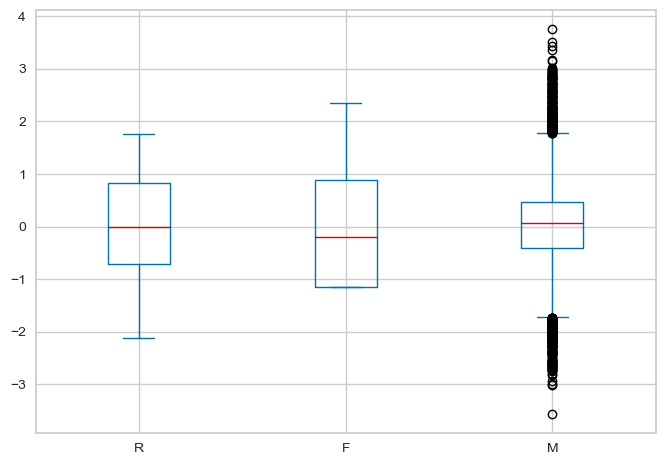

In [47]:
df_rfm_scaled.plot.box();

Agora sim os dados já estão normatizados. As colunas de Recência e Frequência não apresentam mais outliers, enquanto que a coluna de Ticket médio ainda tem, contudo não tem mais nenhum caso muito extremo. Pode-se então partir para a modelagem utilizando este último data frame escalonado.

## Modelling

O modelo de machine learning definido para este projeto de Clusterização será o KMeans. Como ainda não se sabe a quantidade ideal de grupos de clientes a serem definidos, utiliza-se o gráfico abaixo do 'método do cotovelo' para avaliar a quantidade de clusters em função da variância dos resultados.

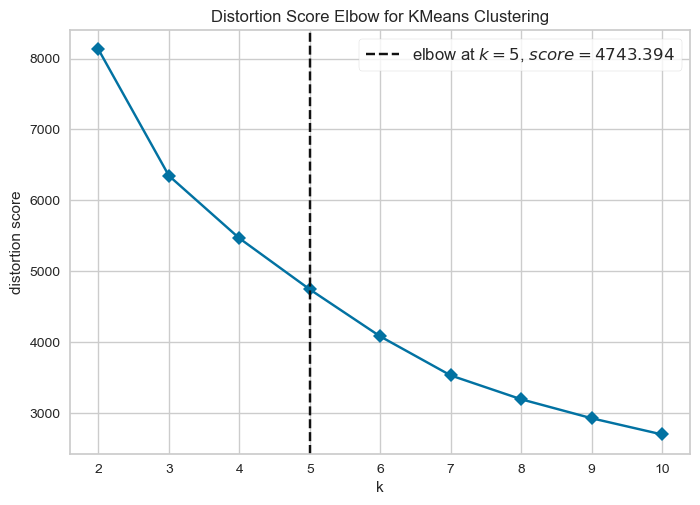

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10, n_init=10), timings=False)

In [48]:
kelbow_visualizer(KMeans(n_init = 10), df_rfm_scaled, k = 10, timings = False)

Pelo resultado acima, a quantidade ideal de clusters seria em torno de 5 grupos. Avaliando agora o comportamento das métricas de Silhouette, Davies Bouldin e Calinski Harabasz conforme a variação do número de clusters.

In [49]:
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfm_scaled.copy()

for k in range(2,11):
  model = KMeans(n_clusters = k, n_init = 10, random_state = 0)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,8129.057157,0.340320,1.164087,2588.024031
3,6347.355988,0.335611,1.088739,2264.161255
4,5465.225211,0.273436,1.214902,1985.424811
5,4745.832064,0.280197,1.158477,1878.289362
6,4080.186861,0.292037,1.014128,1888.454499
7,3529.951497,0.303628,0.980894,1930.909385
8,3193.335021,0.305646,1.007795,1894.193386
9,2926.393005,0.298455,0.982782,1857.490329
10,2696.755456,0.308199,0.997864,1832.135960


Avaliando os resultados das métricas acima, optou-se por adotar um número de clusters igual a 3. Pois, para um k=3, tem-se o segundo melhor valor de silhouette_score, a métrica davies_bouldin_score apresenta um resultado mais baixo que os demais 5 primeiros k (o que é um bom sinal visto que quanto menor o valor desta métrica melhor será a clusterização) e também tem o segundo melhor valor de calinski_harabasz_score.

Além disso, para valores de k acima de 3, a própria interpretabilidade dos resultados ficaria mais dispersa, seria mais difícil encontrar padrões claros que justifiquem dividir os clientes de 3 grupos.

Visualizando os scores de silhouette para cada um dos 3 grupos,

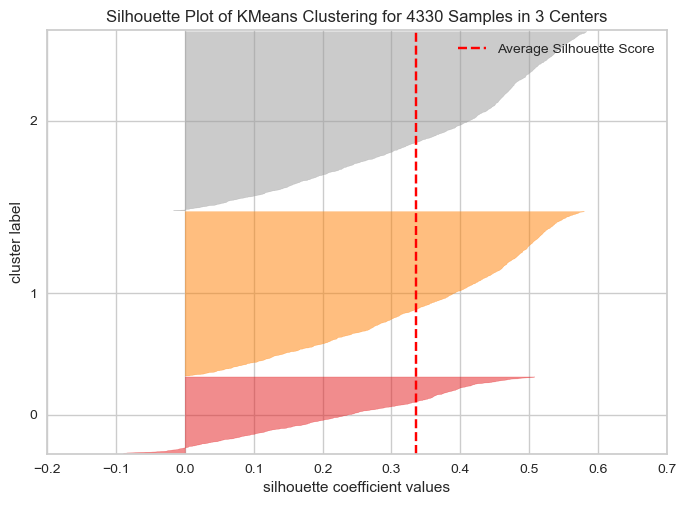

In [50]:
silhouette_visualizer(KMeans(n_clusters = 3, n_init = 10), df_rfm_scaled);

O grupo 2 é o que apresenta valores menores de silhouette score, mas no geral todos os 3 grupos tem resultados muito parecidos, não havendo grande discrepância entre um e outro.

Portanto, com k=3, o modelo de KMeans foi treinado e posteriormente plotou-se um gráfico 3D utilizando a biblioteca plotly importada anteriormente com os resultados calculados pelo modelo.

In [51]:
kmeans = KMeans(n_clusters = 3, n_init = 10)
kmeans_labels = kmeans.fit_predict(df_rfm_scaled)

In [52]:
px.scatter_3d(df_rfm, x='R', y='F', z='M', color = kmeans_labels.astype(str), template = 'plotly_dark')

Percebe-se uma divisão dos 3 grupos, um grupo verde com Frequência e ticket médio bem próximo de zero, outro grupo vermelho com frequência próxima de zero mas com ticket médio e recência variados e por último o grupo roxo com recência próxima de zero mas ticket médio e frequência variados.

Para analisar os 3 em separados, de forma mais clara, plotou-se o gráfico abaixo utilizando os centróides calculados pelo modelo para cada um dos 3 grupos.

In [53]:
# definição do Data Frame com os centróides
centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_rfm_scaled.columns)
centers

,R,F,M
0,0.748365,-0.759305,0.342154
1,-0.758068,0.902186,0.320709
2,-0.130652,-0.154355,-1.498892


Plotando a figura com os 3 gráficos, um para cada cluster,

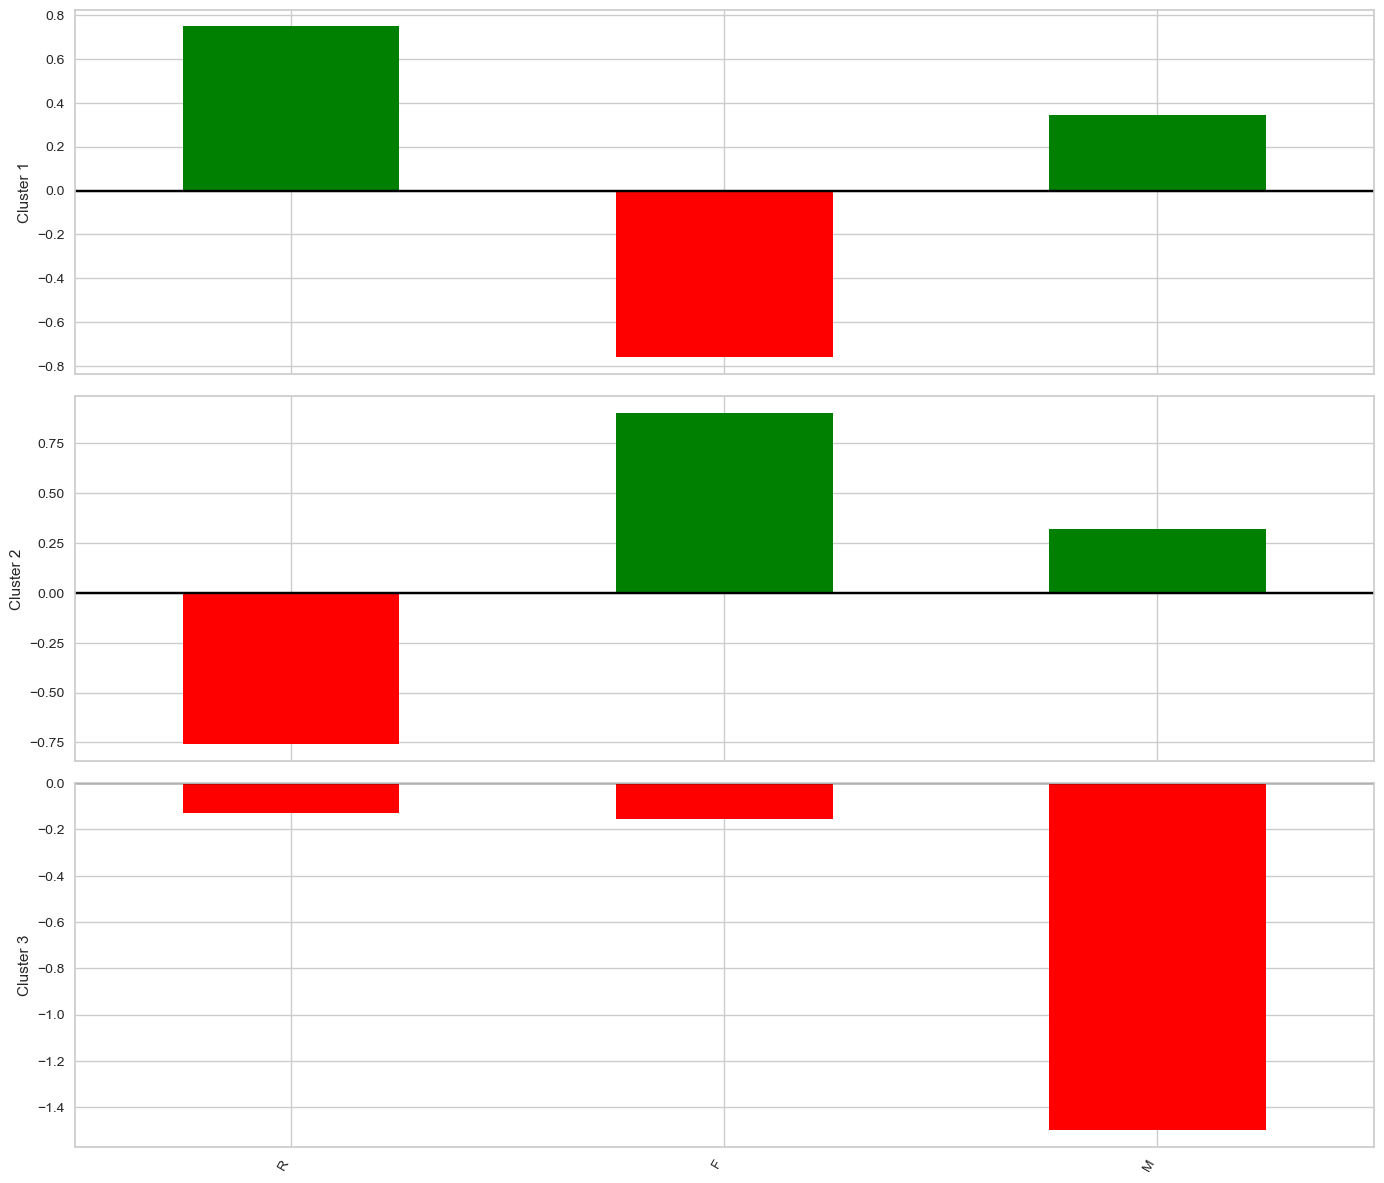

In [54]:
fig, axes = plt.subplots(nrows = 3, figsize = (14,12), sharex = True)

for i, ax in enumerate(axes):
    center = centers.loc[i,:]  # selecionando os valores por linha do dataframe dos centróides

    colors = ['green' if l > 0 else 'red' for l in center]  # definindo um condicional para pintar de verde caso o valor
                                                            # seja positivo ou de vermelho caso seja negativo

    center.plot.bar(ax = ax, color = colors)    # plotando os gráficos

    ax.set_ylabel(f'Cluster {i+1}')             # ajustando o nome do eixo y para cada gráfico

    ax.axhline(color = 'black')                 # definindo a cor do eixo horizontal em y = 0

plt.xticks(rotation = 60, ha = 'right') # ajuste da legenda

plt.tight_layout()  # ajustar o espaço entre os gráficos de forma automática

plt.show()

## Interpretação dos clusters e planos de ação

Avaliando os gráficos acima, o "cluster 1" apresenta o maior índice de Recência e a menor Frequência dentre os 3 grupos. Se trata portanto de um cluster de clientes que compraram pouquíssimos produtos no e-commerce e não realizam compra nenhuma há um bom tempo nesta empresa. Poderíamos classificá-los portanto como clientes "churn".

Já no "cluster 2" tem-se o menor valor de Recência dentre todos os grupos calculados, indicando que se tratam de clientes que realizaram as suas compras a pouquíssimo tempo. Este grupo ainda tem a maior frequência, o que indica que são clientes que compram a bastante tempo neste e-commerce e com um ticket médio relativamente bom.

Por último o "cluster 3" com Recência relativamente baixa, mas com Frequência também baixa e o ticket médio mais baixo dentre os 3 grupos. No todo, poderíamos classificá-los como clientes que compram pouco a pouco tempo e somente produtos mais baratos. Pode-se concluir portanto que se trata de um grupo de clientes mais novos.

Por fim, deixo como sugestão para a empresa alguns pontos de ação voltados para cada um dos grupos avaliados:

- "Cluster 1": esse é o grupo de alerta, famosos clientes "churn". Uma abordagem interessante talvez seja disparar e-mails de novas promoções, produtos, para tentar de alguma forma resgatar estes clientes. Outro ponto importante seria tentar entender o porquê eles pararam de comprar no e-commerce, talvez realizar um estudo de avaliação dos produtos, de forma a separar os que tiveram pior rating médio dentro deste grupo de clientes.

- "Cluster 2": poderia ser denominado também de "Grupo VIP" ou "Fidelidade", algo neste sentido, pois se tratam dos clientes que mais compram no e-commerce. Para este grupo, seria importante oferecer benefícios, cartões fidelidade, pontos de vantagem, acesso a descontos exclusivos de forma a fidelizá-los ainda mais, aumentando ainda o ticket médio geral do grupo e não correr risco de perdê-los para possíveis concorrentes.

- "Cluster 3": este é o grupo de clientes novos na plataforma, compraram pouco e com um investimento mais modesto. Seria interessante para este caso talvez desenvolver um algoritmo de recomendação para entender melhor quais as preferências de produtos destes clientes, de forma a incetivá-los a continuar comprando neste e-commerce.